# **Ocean Mixing Story Group 1**

## Background 
The ocean plays a crucial role in the global carbon cycle by absorbing atmospheric CO₂, having absorbed 38% of all anthropogenic fossil fuel emissions over the industrial era. 

Accurate estimation of air–sea CO₂ flux is critical for understanding the current and future global carbon budget, yet remains challenging due to the sparse and unevenly distributed nature of surface ocean pCO₂ observations. The **Surface Ocean CO₂ Atlas (SOCAT)** database (https://socat.info/) provides the most extensive dataset available, but its coverage is limited to only about 2% of all boxes of 1 degree X 1 degree (= 100km X 100km at the equator) over the last several decades. Data are particularly limited in high-latitude regions and during winter months.

To fill in the gaps in these data, statistical and machine learning (ML) techniques have been widely used to reconstruct global pCO₂ fields by interpolating between observations using environmental predictors such as sea surface temperature (SST), sea surface salinity (SSS), mixed layer depth (MLD), chlorophyll-a (Chl-a), and atmospheric CO₂ (xCO₂).

## How good are these methods? 

This project has two goals:
**Determine the statistical confidance and variability of the pCO₂ reconstructions across the globe** 
**Investigate how adding more observations affects statistical confidence and variability**

Results from this investigation will help answer whether adding data will improve the confidence of the models generally. Going a step deeper, this investigation can give insight into whether it is more important to add more observations in locations historically sampled, or in locations not in the database. Relatedly, this research can inform which areas of the globe are most important to direct funding towards sampling, or to focus other statistical technique to improve model confidence. 

By gaining more confidence in pCO2 reconstructions, scientists can more accurately answer questions related to carbon budgets and other scientific and socio-economic questions related to climate change. 

## Information about the ML model used

## Information about Adding Observations

In section 2, there is an investigation of how adding data to the model affects statistical confidence and variability. In particular, we investigate adding data across 2 dimensions:

1. Adding more observations at locations that have historically been sampled. 
2. Adding new locations, not previously sampled for pCO2 concentrations.

For adding more observations to locations that have historically been sampled, chose to do XXXX(add later depending on what works)

In particular, this research will focus on adding samples to 4 Ocean Basins undersampled in the research: Southern Ocean, Indian Ocean, Arctic Areas, and Pacific Ocean between Australia and South America.  

In [1]:
your_username = 'spariser'  # username of the person running the code. Reviewers should also change this to their own username.

#To allow the reviewer to access the saved files, provide notebook owner's username here:  
owner_username = 'spariser'  # Reviewer should not change this name

# 0. Setup Workspace and Import Packages
We use %%capture to suppress output and keep the notebook clean. However, feel free to remove it if you want to check warnings or logs.


In [2]:
%%capture
!pip install tensorflow
!pip install keras

In [3]:
%%capture
### standard imports ###
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs
### Python file with supporting functions ###
# standard imports
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sys
# Redirect all low-level stderr output
sys.stderr = open(os.devnull, 'w')

import datetime
from collections import defaultdict
import random
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth',100)
import csv
import cmocean as cm

# machine learning libraries
import xgboost as xgb     
from xgboost import XGBRegressor

# Change to the parent directory of the current working directory. (Run only once—otherwise it will keep moving up the directory tree)
os.chdir(os.path.dirname(os.getcwd()))
print("Current working directory:", os.getcwd())

# Python file with supporting functions
import lib.residual_utils as supporting_functions
from lib.visualization import *
from lib.bias_figure2 import concat_datasets, XarrayEvaluator
from lib.corr_figure3 import eval_spatial


E0000 00:00:1744592031.555709     115 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744592031.560295     115 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744592031.572123     115 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744592031.572147     115 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744592031.572148     115 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744592031.572150     115 computation_placer.cc:177] computation placer already registered. Please check linka

In [4]:
### Setting the date range to unify the date type ###

# Define date range
date_range_start = '2004-01-01T00:00:00.000000000'
date_range_end = '2023-12-31T00:00:00.000000000'

# create date vector, adds 14 days to start & end
dates = pd.date_range(start=date_range_start, 
                      end=date_range_end,freq='MS')


init_date = str(dates[0].year) + format(dates[0].month,'02d')
fin_date = str(dates[-1].year) + format(dates[-1].month,'02d')

# 1. Surface ocean pCO2: A sparse data challenge

Here, we visualize all SOCAT data for the period selected for this analysis (default is 2004-2023). 

We plot the total number of months of available data at each 1 degree X 1 degree location (100x100km at the equator). 

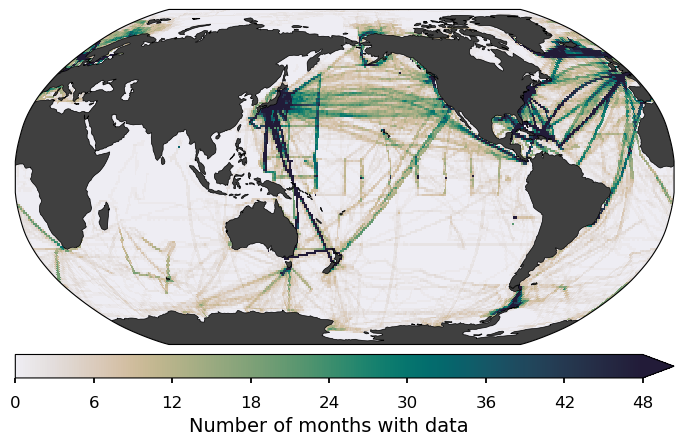

In [5]:
zarr_dir = 'gs://leap-persistent/abbysh/zarr_files_'
socat_path = f"{zarr_dir}/socat_mask_feb1982-dec2023.zarr"
socat_mask_data = xr.open_zarr(socat_path).sel(time=slice(str(dates[0]),str(dates[-1])))

non_zero_counts = (socat_mask_data.socat_mask != 0).sum(dim="time")
plot_style = "seaborn-v0_8-talk"

with plt.style.context(plot_style):
    fig = plt.figure(figsize=(8.5, 11)) # fig = plt.figure(dpi=300)
    worldmap = SpatialMap2(fig=fig, region='world', 
                   cbar_mode='each',
                   colorbar=True,
                   cbar_location='bottom',
                   nrows_ncols=[1,1])
    
    vrange = [0, 48, 6]
    cmap = cm.cm.rain
    data = xr_add_cyclic_point(non_zero_counts, cyclic_coord='xlon')
    data = data.assign_coords(xlon=(((data.xlon + 180) % 360) ))
    sub = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                      vrange=vrange[0:2], cmap=cmap, ax=0, linewidth_coast=0.5)
    
    col = worldmap.add_colorbar(sub, ax=0,extend='max')
    worldmap.set_cbar_xlabel(col, 'Number of months with data', fontsize=14)
    worldmap.set_ticks(col, vrange[0], vrange[1], vrange[2])
    col.ax.tick_params(labelsize=12)
    plt.show()

In [11]:
#non_zero_counts
socat_mask_data

<xarray.Dataset> Size: 124MB
Dimensions:     (time: 240, ylat: 180, xlon: 360)
Coordinates:
  * time        (time) datetime64[ns] 2kB 2004-01-01 2004-02-01 ... 2023-12-01
  * xlon        (xlon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * ylat        (ylat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Data variables:
    socat_mask  (time, ylat, xlon) float64 124MB dask.array<chunksize=(52, 45, 90), meta=np.ndarray>

In [95]:
#socat_mask_data.where(non_zero_counts == 0, socat_mask_data.max(dim='ylat'))
indices = non_zero_counts.where(non_zero_counts == 5).coords
index_list = list(zip(indices['xlon'].values, indices['ylat'].values))
#print(index_list[0])
#-179.5, -89.5
index_list[50][1]
#non_zero_counts.sel(xlon = -179.5, ylat = -89.5).values
test = non_zero_counts.where(non_zero_counts == 5)
test[14][7]

socat_mask_data.sel(xlon = -172.5, ylat = -75.5).values

<bound method Mapping.values of <xarray.Dataset> Size: 4kB
Dimensions:     (time: 240)
Coordinates:
  * time        (time) datetime64[ns] 2kB 2004-01-01 2004-02-01 ... 2023-12-01
    xlon        float64 8B -172.5
    ylat        float64 8B -75.5
Data variables:
    socat_mask  (time) float64 2kB dask.array<chunksize=(52,), meta=np.ndarray>>

In [96]:
#if there's real world data sampled at the location, say it's sampled at maximum amount seen globally (266 times)
#no change in distribution of sampling
max_val_glob_number = non_zero_counts.where(non_zero_counts == 0, non_zero_counts.max())
#first one, want to find the location of the max amount of sampling seen globally
max_lons = non_zero_counts.max(dim="ylat").idxmax(dim="xlon")
max_lats = non_zero_counts.max(dim="xlon").idxmax(dim="ylat")
max_values = socat_mask_data.sel(ylat=max_lats,xlon=max_lons)

socat_mask_max = socat_mask_data.where(non_zero_counts == 0,max_values)

#mask_data_max_loc = socat_mask_data.where(
#if there's real world data sampled at the location, say it's sampled at maximum amount seen at that longitude 
#no change in distribution of sampling
max_val_lat_loc = non_zero_counts.where(non_zero_counts == 0, non_zero_counts.max(dim='ylat'))
socat_mask_maxlat = socat_mask_data.where(non_zero_counts == 0,socat_mask_data.max(dim='ylat'))

#if there's real world data sampled at the location, if sampled less than see globally, say it's sampled at average amount seen globally (5 months)
#no change in distribution of sampling
indices = non_zero_counts.where(non_zero_counts == 5).coords
index_list = list(zip(indices['xlon'].values, indices['ylat'].values))

mean_val_glob_loc = non_zero_counts.where((non_zero_counts > non_zero_counts.mean())|(non_zero_counts == 0), non_zero_counts.mean())
socat_val_glob_loc = socat_mask_data.where((non_zero_counts > non_zero_counts.mean())|(non_zero_counts == 0), socat_mask_data.sel(xlon = -172.5, ylat = -75.5))

In [97]:
#boolean_glob_loc = non_zero_counts.where(non_zero_counts > 0, 
socat_val_glob_loc.values

<bound method Mapping.values of <xarray.Dataset> Size: 124MB
Dimensions:     (time: 240, ylat: 180, xlon: 360)
Coordinates:
  * time        (time) datetime64[ns] 2kB 2004-01-01 2004-02-01 ... 2023-12-01
  * xlon        (xlon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * ylat        (ylat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
Data variables:
    socat_mask  (time, ylat, xlon) float64 124MB dask.array<chunksize=(52, 45, 90), meta=np.ndarray>>

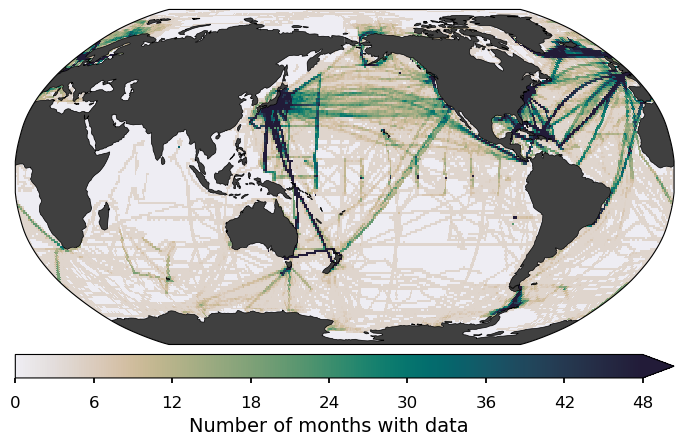

In [11]:
zarr_dir = 'gs://leap-persistent/abbysh/zarr_files_'
socat_path = f"{zarr_dir}/socat_mask_feb1982-dec2023.zarr"
socat_mask_data = xr.open_zarr(socat_path).sel(time=slice(str(dates[0]),str(dates[-1])))

non_zero_counts = (socat_mask_data.socat_mask != 0).sum(dim="time")
plot_style = "seaborn-v0_8-talk"

with plt.style.context(plot_style):
    fig = plt.figure(figsize=(8.5, 11)) # fig = plt.figure(dpi=300)
    worldmap = SpatialMap2(fig=fig, region='world', 
                   cbar_mode='each',
                   colorbar=True,
                   cbar_location='bottom',
                   nrows_ncols=[1,1])
    
    vrange = [0, 48, 6]
    cmap = cm.cm.rain
    data = xr_add_cyclic_point(mean_val_glob_loc , cyclic_coord='xlon')
    data = data.assign_coords(xlon=(((data.xlon + 180) % 360) ))
    sub = worldmap.add_plot(lon=data['xlon'], lat=data['ylat'], data=data, 
                      vrange=vrange[0:2], cmap=cmap, ax=0, linewidth_coast=0.5)
    
    col = worldmap.add_colorbar(sub, ax=0,extend='max')
    worldmap.set_cbar_xlabel(col, 'Number of months with data', fontsize=14)
    worldmap.set_ticks(col, vrange[0], vrange[1], vrange[2])
    col.ax.tick_params(labelsize=12)
    plt.show()

In [12]:
##Will take this out, but checking for 
#Pzeros = pacific.where(pacific ==0)
pacific25 = non_zero_counts.sel(xlon=slice(-95,-90),ylat=slice(-46,-31))
pacific50 = non_zero_counts.sel(xlon=slice(-95,-90),ylat=slice(-46,-36))
pacific100 = non_zero_counts.sel(xlon=slice(-97,-87),ylat=slice(-46,-36))
southern25 = non_zero_counts.sel(xlon=slice(105,110),ylat=slice(-80,-75))
southern50 = non_zero_counts.sel(xlon=slice(100,110),ylat=slice(-80,-75))
southern100 = non_zero_counts.sel(xlon=slice(100,110),ylat=slice(-80,-70))

indian25 = non_zero_counts.sel(xlon=slice(75,80),ylat=slice(-10,-5))
indian50 = non_zero_counts.sel(xlon=slice(75,85),ylat=slice(-10,-5))
indian100 = non_zero_counts.sel(xlon=slice(75,85),ylat=slice(-10,0))

arctic100 = non_zero_counts.sel(xlon=slice(-75,-65),ylat=slice(50,60))
arctic50 = non_zero_counts.sel(xlon=slice(-75,-65),ylat=slice(55,60))
arctic25 = non_zero_counts.sel(xlon=slice(-75,-70),ylat=slice(55,60))

non_zero_counts.sel(xlon=slice(90,110),ylat=slice(55,75)).values

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0,

In [115]:
#Adding 25 values to undersampled oceans (Pacific ocean west of Chile, Southern Ocean, Indian Ocean, & Arctic Ocean); 
#these locations are unsampled in the dataset & are replaced with average global sampling of 4.4 months of sampling
add25_oceans = non_zero_counts.copy()
add25_socat = socat_mask_data.copy()
add25_oceans[-95:-90,-46:-31] = non_zero_counts.mean() #pacific
add25_socat['socat_mask'].loc[:, -46:-31, -95:-90] = socat_mask_data.sel(xlon = -172.5, ylat = -75.5).values
add25_oceans[105:110,-80:-75] = non_zero_counts.mean() #southern ocean
add25_socat['socat_mask'].loc[:, -80:-75, 105:110] = socat_mask_data.sel(xlon = -172.5, ylat = -75.5).values
add25_oceans[75:80,-10:-5] = non_zero_counts.mean() #indian ocean
add25_socat['socat_mask'].loc[:, -10:-5, 75:80] = socat_mask_data.sel(xlon = -172.5, ylat = -75.5).values
add25_oceans[-75:-70,55:60] = non_zero_counts.mean() #arctic ocean
add25_socat['socat_mask'].loc[:, 55:60, -75:-70] = socat_mask_data.sel(xlon = -172.5, ylat = -75.5).values

#Adding 50 values to undersampled oceans, in currently unsampled locations
add50_oceans = non_zero_counts.copy()
add50_socat = socat_mask_data.copy()
add50_oceans[-95:-90,-46:-36] = non_zero_counts.mean() #pacific 
add50_socat['socat_mask'].loc[:, -46:-36, -95:-90] = socat_mask_data.sel(xlon = -172.5, ylat = -75.5).values
add50_oceans[100:110,-80:-75] = non_zero_counts.mean() #southern ocean
add50_socat['socat_mask'].loc[:, -80:-75, 100:110] = socat_mask_data.sel(xlon = -172.5, ylat = -75.5).values
add50_oceans[75:85,-10:-5] = non_zero_counts.mean() #indian ocean
add50_socat['socat_mask'].loc[:, -10:-5, 75:85] = socat_mask_data.sel(xlon = -172.5, ylat = -75.5).values
add50_oceans[-75:-65,55:60] = non_zero_counts.mean() #arctic ocean
add50_socat['socat_mask'].loc[:, 55:60, -75:-65] = socat_mask_data.sel(xlon = -172.5, ylat = -75.5).values

#Adding 100 values to undersampled oceans, in currently unsampled locations
add100_oceans = non_zero_counts.copy()
add100_socat = socat_mask_data.copy()
add100_oceans[-97:-87,-46:-36] = non_zero_counts.mean() #pacific 
add100_socat['socat_mask'].loc[:, -46:-36, -97:-87] = socat_mask_data.sel(xlon = -172.5, ylat = -75.5).values
add100_oceans[100:110,-80:-70] = non_zero_counts.mean() #southern ocean
add100_socat['socat_mask'].loc[:, -80:-70, 100:110] = socat_mask_data.sel(xlon = -172.5, ylat = -75.5).values
add100_oceans[75:85,-10:0] = non_zero_counts.mean() #indian ocean
add100_socat['socat_mask'].loc[:, -10:0, 75:85] = socat_mask_data.sel(xlon = -172.5, ylat = -75.5).values
add100_oceans[-75:-65,50:60] = non_zero_counts.mean() #arctic ocean
add100_socat['socat_mask'].loc[:, 50:60, -75:-65] = socat_mask_data.sel(xlon = -172.5, ylat = -75.5).values

#Adding 200 values to undersampled oceans, in currently unsampled locations
add200_oceans = non_zero_counts.copy()
add200_socat = socat_mask_data.copy()
add200_oceans[-97:-87,-46:-36] = non_zero_counts.mean() #pacific1
add200_socat['socat_mask'].loc[:, -46:-36, -97:-87] = socat_mask_data.sel(xlon = -172.5, ylat = -75.5).values
add200_oceans[-130:-120,-45:-35] = non_zero_counts.mean() #pacific2
add200_socat['socat_mask'].loc[:, -45:-35, -130:-120] = socat_mask_data.sel(xlon = -172.5, ylat = -75.5).values
add200_oceans[95:115,-80:-70] = non_zero_counts.mean() #southern ocean
add200_socat['socat_mask'].loc[:, -80:-70, 95:115] = socat_mask_data.sel(xlon = -172.5, ylat = -75.5).values
add200_oceans[75:85,-11:9] = non_zero_counts.mean() #indian ocean
add200_socat['socat_mask'].loc[:, -11:9, 75:85] = socat_mask_data.sel(xlon = -172.5, ylat = -75.5).values
add200_oceans[-75:-65,50:60] = non_zero_counts.mean() #arctic ocean1
add200_socat['socat_mask'].loc[:, 50:60, -75:-65] = socat_mask_data.sel(xlon = -172.5, ylat = -75.5).values
add200_oceans[95:105,65:75] = non_zero_counts.mean() #arctic ocean2
add200_socat['socat_mask'].loc[:, 65:75, 95:105] = socat_mask_data.sel(xlon = -172.5, ylat = -75.5).values

#Adding 500 values to undersampled oceans, in currently unsampled locations
add400_oceans = non_zero_counts.copy()
add400_socat = socat_mask_data.copy()
add400_oceans[-97:-87,-46:-36] = non_zero_counts.mean() #pacific1
add400_socat['socat_mask'].loc[:, -46:-36, -97:-87] = socat_mask_data.sel(xlon = -172.5, ylat = -75.5).values
add400_oceans[-130:-110,-45:-35] = non_zero_counts.mean() #pacific2
add400_socat['socat_mask'].loc[:, -45:-35, -130:-120] = socat_mask_data.sel(xlon = -172.5, ylat = -75.5).values
add400_oceans[-141:-121,-32:-27] = non_zero_counts.mean() #pacific3
add400_socat['socat_mask'].loc[:, -32:-27, -141:-121] = socat_mask_data.sel(xlon = -172.5, ylat = -75.5).values
add400_oceans[90:110,-90:-70] = non_zero_counts.mean() #southern ocean
add400_socat['socat_mask'].loc[:, -90:-70, 90:110] = socat_mask_data.sel(xlon = -172.5, ylat = -75.5).values
add400_oceans[75:85,-11:9] = non_zero_counts.mean() #indian ocean1
add400_socat['socat_mask'].loc[:, -11:9, 75:85] = socat_mask_data.sel(xlon = -172.5, ylat = -75.5).values
add400_oceans[70:90,-30:-25] = non_zero_counts.mean() #indian ocean2
add400_socat['socat_mask'].loc[:, -30:-25, 70:90] = socat_mask_data.sel(xlon = -172.5, ylat = -75.5).values
add400_oceans[-75:-65,50:60] = non_zero_counts.mean() #arctic ocean1
add400_socat['socat_mask'].loc[:, 50:60, -75:-65] = socat_mask_data.sel(xlon = -172.5, ylat = -75.5).values
add400_oceans[90:110,55:75] = non_zero_counts.mean() #arctic ocean2
add200_socat['socat_mask'].loc[:, 55:75, 90:110] = socat_mask_data.sel(xlon = -172.5, ylat = -75.5).values